In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import sort
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error, make_scorer
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
sns.set_theme()
# Hàm chuyển đổi từ K sang °C
def kelvin_to_celsius(kelvin):
    celsius = kelvin - 273.15
    return celsius

# hàm chuyển đổi đơn vị kg/m**2/s sang mm/day
def donvi(pr):
  mm = pr * 86400
  if mm < 0:
    mm = 0;
  return mm

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    # df['dayofyear'] = df.index.dayofyear
    # df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week
    return df

# Tính toán R-squared
def r_squared(actual, predicted):
    mean_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_actual) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

#Tính toán NSE
def NSE(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

nse_scorer = make_scorer(NSE)

# **DaTa Mining**

In [ ]:
data = pd.read_excel('/content/sample_data/GLDF_ESM4 1980-2014_model.xlsx')
data

,datetime,relative_hum,specific_hum,pr,snowfall_flux,air_pressure,shortwave,longwave,wind_speed,temp,max_temp,min_temp,pr_real,month,date,year,bias
0,1980-01-01,24.13064,0.016942,0.000000,0.0,100873.2,199.88780,406.9503,1.762531,299.5450,304.6036,295.8168,0.0,1,1,1980,0.000000
1,1980-01-02,23.92169,0.018031,0.352933,0.0,100867.4,214.30970,407.6529,1.208650,299.7536,304.6317,295.1970,0.0,1,2,1980,-0.352933
2,1980-01-03,21.95358,0.018134,0.158529,0.0,100819.8,211.68070,409.7419,0.773226,299.8491,304.8334,296.2072,0.0,1,3,1980,-0.158529
3,1980-01-04,23.31655,0.018510,0.000000,0.0,100685.9,197.04600,414.0836,0.968103,300.1741,304.9903,296.0473,0.0,1,4,1980,0.000000
4,1980-01-05,21.73940,0.018636,0.000000,0.0,100639.3,206.42960,416.6946,1.069319,300.4881,305.1294,295.9986,0.0,1,5,1980,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,2014-12-27,27.36200,0.019793,9.539493,0.0,100345.6,118.55980,435.8821,2.377360,299.9697,303.0520,298.2183,0.0,12,27,2014,-9.539493
12780,2014-12-28,25.95302,0.019591,8.122045,0.0,100541.2,82.63331,432.9671,2.534230,299.7074,301.6453,297.7395,0.0,12,28,2014,-8.122045
12781,2014-12-29,22.23770,0.019387,0.633353,0.0,100716.1,179.35120,423.6180,1.188818,300.5147,303.9991,297.9998,0.0,12,29,2014,-0.633353
12782,2014-12-30,22.39242,0.019470,0.764738,0.0,100754.3,200.04400,420.7432,1.053552,300.5270,304.1916,298.0242,0.0,12,30,2014,-0.764738


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12784 entries, 0 to 12783
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       12784 non-null  datetime64[ns]
 1   relative_hum   12784 non-null  float64       
 2   specific_hum   12784 non-null  float64       
 3   pr             12784 non-null  float64       
 4   snowfall_flux  12784 non-null  float64       
 5   air_pressure   12784 non-null  float64       
 6   shortwave      12784 non-null  float64       
 7   longwave       12784 non-null  float64       
 8   wind_speed     12784 non-null  float64       
 9   temp           12784 non-null  float64       
 10  max_temp       12784 non-null  float64       
 11  min_temp       12784 non-null  float64       
 12  pr_real        12784 non-null  float64       
 13  month          12784 non-null  int64         
 14  date           12784 non-null  int64         
 15  year           1278

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
relative_hum,12784.0,5.015755e+01,2.640189e+01,5.389629,24.880855,48.667860,77.700468,9.618634e+01
specific_hum,12784.0,1.871491e-02,2.127315e-03,0.010463,0.017286,0.019453,0.020355,2.321581e-02
pr,12784.0,4.616700e+00,9.057301e+00,0.000000,0.000000,0.000000,7.399729,1.436217e+02
snowfall_flux,12784.0,1.395252e-10,2.305120e-09,0.000000,0.000000,0.000000,0.000000,1.360015e-07
air_pressure,12784.0,1.007165e+05,2.054320e+02,99943.460000,100572.000000,100703.750000,100851.125000,1.015122e+05
shortwave,12784.0,2.109686e+02,4.626152e+01,27.904250,185.339175,217.608400,243.418125,3.120026e+02
longwave,12784.0,4.183537e+02,1.555408e+01,349.779300,410.024150,423.194050,429.436850,4.533990e+02
wind_speed,12784.0,2.236112e+00,7.765175e-01,0.517794,1.660110,2.135401,2.710103,7.370327e+00
temp,12784.0,3.008373e+02,1.308457e+00,295.128300,300.085425,300.850350,301.567750,3.053832e+02
max_temp,12784.0,3.057115e+02,1.795277e+00,297.980100,304.693025,305.647050,306.706775,3.110975e+02


In [ ]:
data['temp'] = data['temp'].apply(kelvin_to_celsius)
data['max_temp'] = data['max_temp'].apply(kelvin_to_celsius)
data['min_temp'] = data['min_temp'].apply(kelvin_to_celsius)

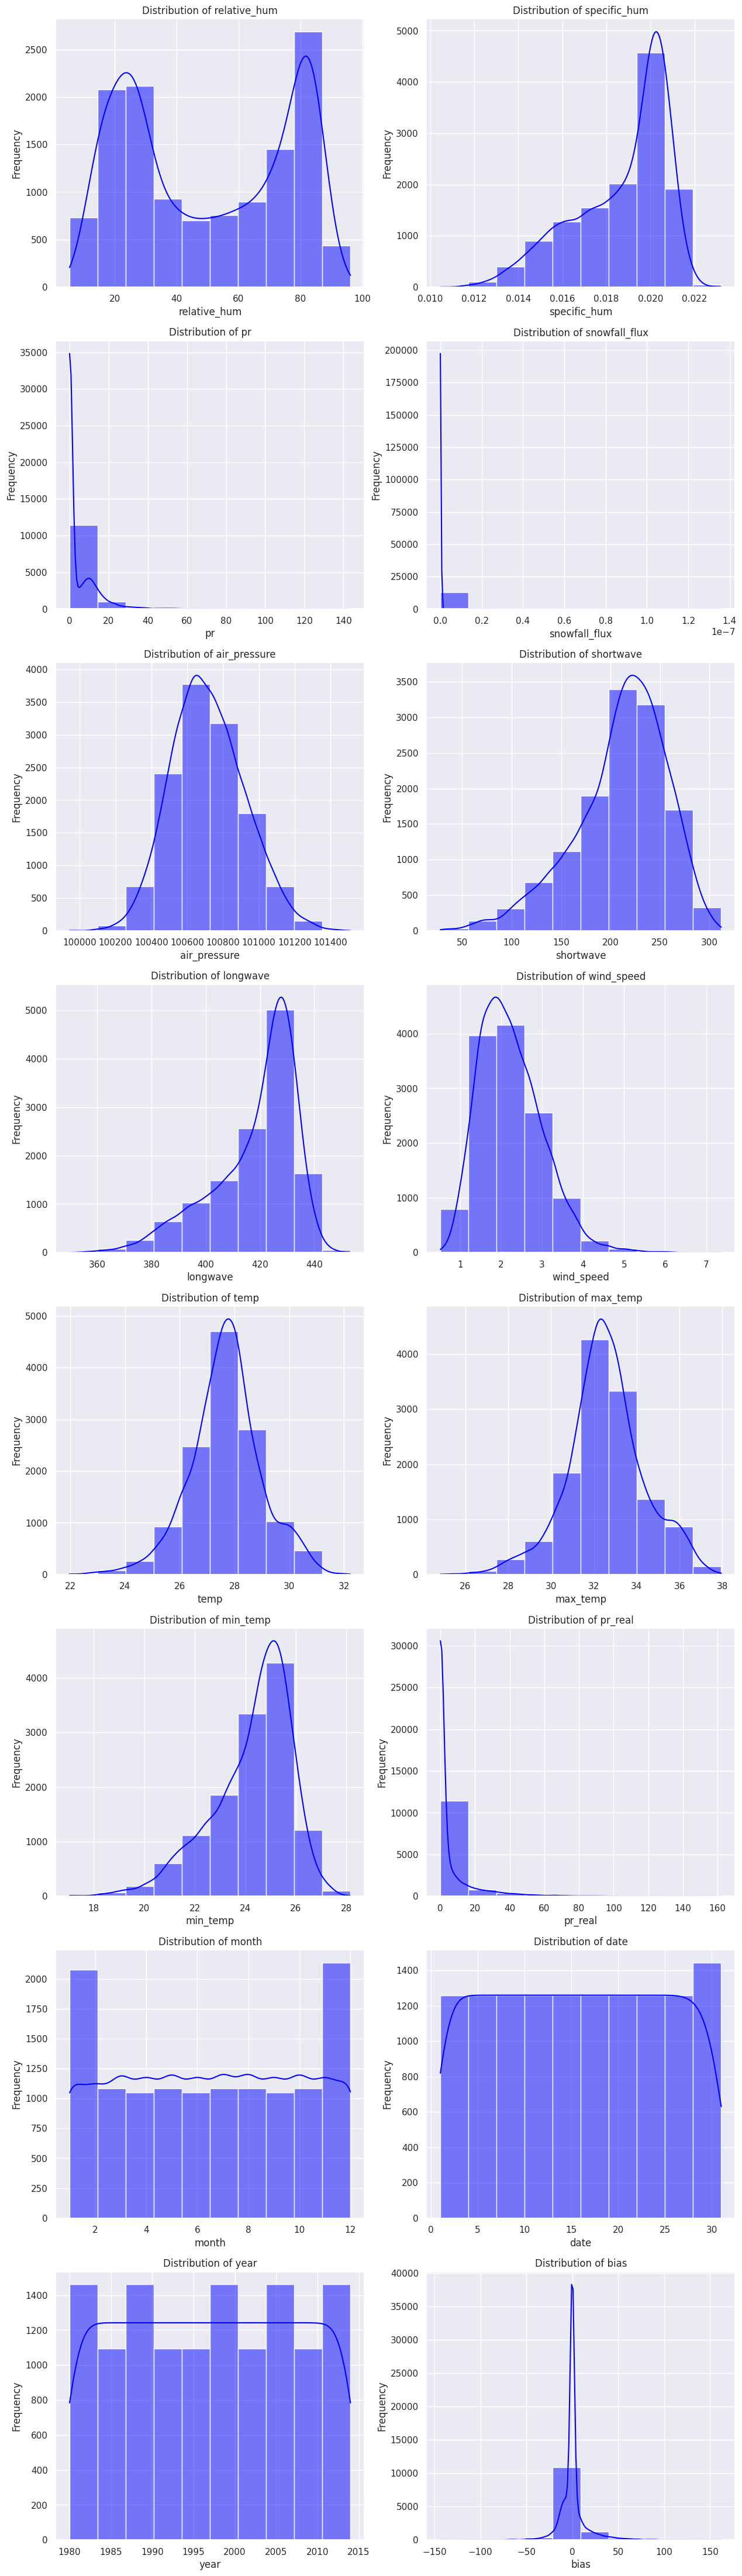

In [ ]:
numerical_attributes = data.select_dtypes(include=['number']).columns
num_rows_num = (len(numerical_attributes) - 1) // 2 + 1

# Create subplots for numerical attributes
plt.figure(figsize=(15, 7 * num_rows_num))
for i, attr in enumerate(numerical_attributes):
    plt.subplot(num_rows_num, 2, i + 1)
    sns.histplot(data[attr], bins=10, kde=True, color='blue')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {attr}')

In [ ]:
data = data.set_index('DateTime')
data.index = pd.to_datetime(data.index)
data = create_features(data)

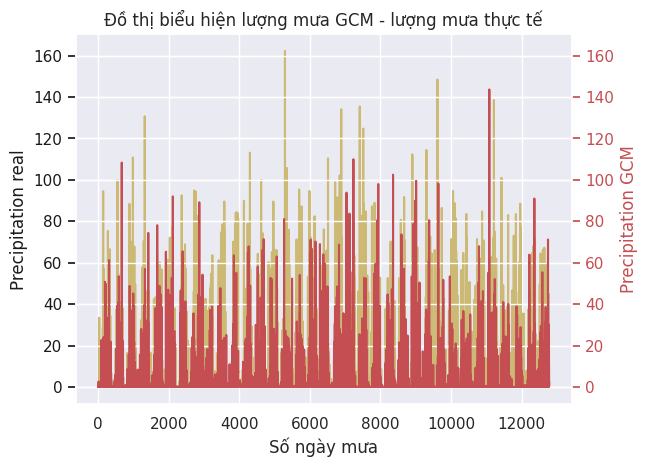

In [ ]:
# Dữ liệu cho trục y thứ nhất
x = range(len(data.index))
y1 = data['Precipitation_real']

# Tạo đối tượng Axes thứ nhất
fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='y')
ax1.set_xlabel('Số ngày mưa')
ax1.set_ylabel('Precipitation real', color='k')
ax1.tick_params('y', colors='k')

# Dữ liệu cho trục y thứ hai
y2 = data['PRECIPITATION']

# Tạo đối tượng Axes thứ hai
ax2 = ax1.twinx()
ax2.plot(x, y2, 'r')
ax2.set_ylabel('Precipitation GCM', color='r')
ax2.tick_params('y', colors='r')
# Đặt giới hạn cho trục y2 dựa trên giới hạn của trục y1
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)

# Tiêu đề
plt.title('Đồ thị biểu hiện lượng mưa GCM - lượng mưa thực tế')

# Hiển thị đồ thị
plt.show()

In [ ]:
# Nhóm dữ liệu theo 'year' và 'month', tính giá trị trung bình của 'Precipitation' và 'Precipitation_real'
monthly_avg_precipitation = data.groupby(['year', 'month'])['PRECIPITATION'].mean().reset_index()
monthly_avg_precipitation_real = data.groupby(['year', 'month'])['Precipitation_real'].mean().reset_index()

# Đổi tên cột cho dễ đọc
monthly_avg_precipitation.rename(columns={'PRECIPITATION': 'Avg_Precipitation'}, inplace=True)
monthly_avg_precipitation_real.rename(columns={'Precipitation_real': 'Avg_Precipitation_real'}, inplace=True)

# Thêm cột giá trị trung bình hàng tháng của 'Precipitation' và 'Precipitation_real' vào DataFrame gốc
data = data.merge(monthly_avg_precipitation, on=['year', 'month'], how='left')
data = data.merge(monthly_avg_precipitation_real, on=['year', 'month'], how='left')

# In ra DataFrame sau khi đã thêm cột giá trị trung bình hàng tháng của 'Precipitation' và 'Precipitation_real'
data

,NEAR-SURFACE RELATIVE HUMIDITY (mm/day),NEAR-SURFACE SPECIFIC HUMIDITY,PRECIPITATION,SNOWFALL FLUX,SURFACE AIR PRESSURE,SURFACE DOWNWELLING SHORT WARE RADIATION,SURFACE DOWNWELLING LONGWARE RADIATION,NEAR-SURFACE WIND SPEED,NEAR-SURFACE AIR TEPERATURE,DAILY MAXIMUM NEAR-SURFACE AIR TEPERATURE,DAILY MINIMUM NEAR-SURFACE AIR TEPERATURE,Precipitation_real,quarter,month,year,Avg_Precipitation,Avg_Precipitation_real
0,24.13064,0.016942,0.000000,0.0,100873.2,199.88780,406.9503,1.762531,26.3950,31.4536,22.6668,0.0,1,1,1980,0.196739,1.151613
1,23.92169,0.018031,0.352933,0.0,100867.4,214.30970,407.6529,1.208650,26.6036,31.4817,22.0470,0.0,1,1,1980,0.196739,1.151613
2,21.95358,0.018134,0.158529,0.0,100819.8,211.68070,409.7419,0.773226,26.6991,31.6834,23.0572,0.0,1,1,1980,0.196739,1.151613
3,23.31655,0.018510,0.000000,0.0,100685.9,197.04600,414.0836,0.968103,27.0241,31.8403,22.8973,0.0,1,1,1980,0.196739,1.151613
4,21.73940,0.018636,0.000000,0.0,100639.3,206.42960,416.6946,1.069319,27.3381,31.9794,22.8486,0.0,1,1,1980,0.196739,1.151613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,27.36200,0.019793,9.539493,0.0,100345.6,118.55980,435.8821,2.377360,26.8197,29.9020,25.0683,0.0,4,12,2014,7.292964,1.612903
12780,25.95302,0.019591,8.122045,0.0,100541.2,82.63331,432.9671,2.534230,26.5574,28.4953,24.5895,0.0,4,12,2014,7.292964,1.612903
12781,22.23770,0.019387,0.633353,0.0,100716.1,179.35120,423.6180,1.188818,27.3647,30.8491,24.8498,0.0,4,12,2014,7.292964,1.612903
12782,22.39242,0.019470,0.764738,0.0,100754.3,200.04400,420.7432,1.053552,27.3770,31.0416,24.8742,0.0,4,12,2014,7.292964,1.612903


In [ ]:
# Tạo chuỗi thời gian từ tháng 1/1980 đến tháng 12/2014
date = pd.date_range(start="1980-01-01", end="2014-12-31", freq='D')

df = data.copy()
df = df.set_index(date)

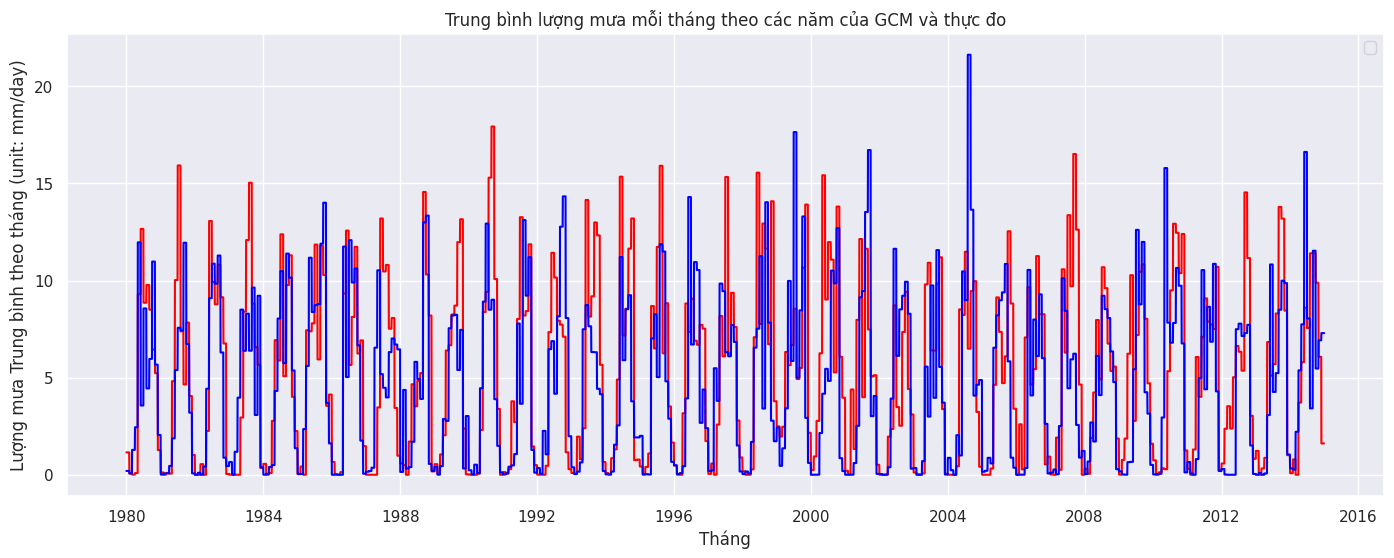

In [ ]:
# bar chart
plt.figure(figsize=(17, 6))
plt.plot(df.index, df['Avg_Precipitation_real'], color='red')
plt.plot(df.index, df['Avg_Precipitation'], color='blue')
# Đặt nhãn cho trục x và y
plt.xlabel('Tháng')
plt.ylabel('Lượng mưa Trung bình theo tháng (unit: mm/day)')
# Đặt tiêu đề cho biểu đồ
plt.title('Trung bình lượng mưa mỗi tháng theo các năm của GCM và thực đo')
# Hiển thị biểu đồ
plt.legend()
plt.show()

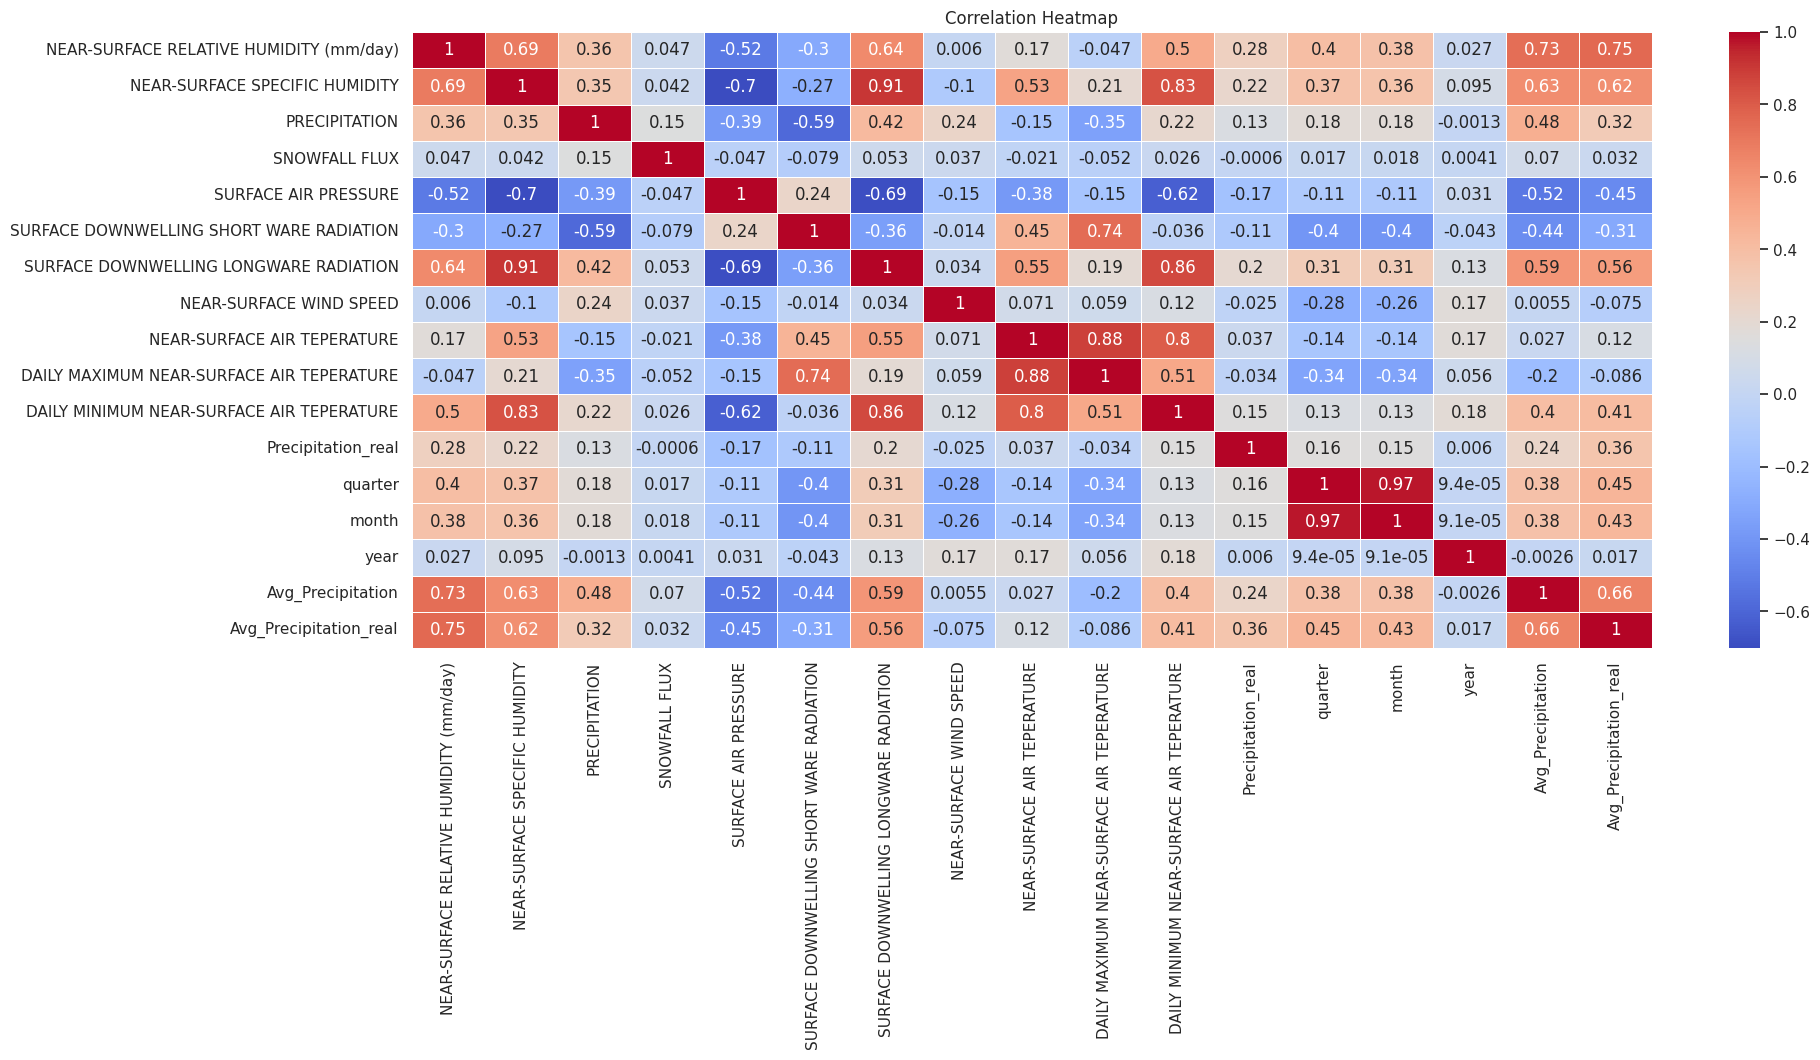

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
# Create a heatmap
plt.figure(figsize=(20, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# **Train / Test Split**

In [ ]:
X = df.drop(columns=['Precipitation_real'])
y = df['Precipitation_real']

standar = StandardScaler()
X_preprocessing = standar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **XGBoost**

**BaseLine**

In [ ]:
#huấn luyện mô hình

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

#đánh giá hiệu suất tập train
y_pred_train = xgb_model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred_train)
print('Mean absolute Error:', mae)

rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Root mean squared Error:', rmse)

r = r_squared(actual=y_train.values, predicted=y_pred_train)
print("R_squared:", r)

nse = NSE(y_true=y_train.values, y_pred=y_pred_train)
print("NSE:", nse)

Mean absolute Error: 2.8875270141802245
Root mean squared Error: 4.95277869331392
R_squared: 0.8423640134195064
NSE: 0.8423640134195064


In [ ]:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Mean absolute Error: 7.2910222051011395
Root mean squared Error: 14.084518840584105
NSE: -0.03973890316590256


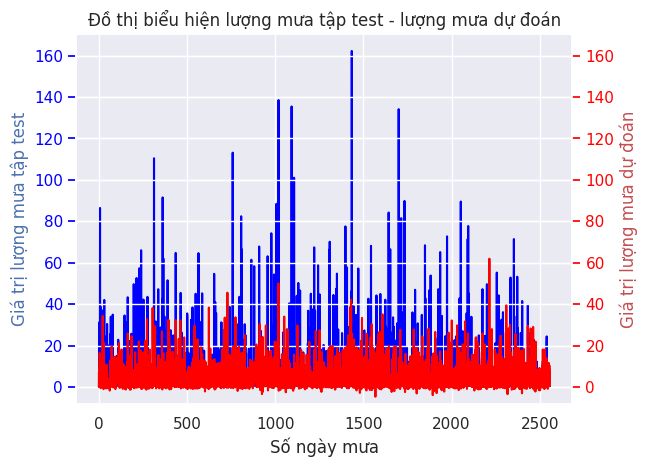

In [ ]:
#đánh giá hiệu suất trên tập test
y_pred_test = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
print('Mean absolute Error:', mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Root mean squared Error:', rmse)

nse = NSE(y_true=y_test.values, y_pred=y_pred_test)
print("NSE:", nse)

# Dữ liệu cho trục y thứ nhất
x = range(len(y_test))
y1 = y_test

# Tạo đối tượng Axes thứ nhất
fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Số ngày mưa')
ax1.set_ylabel('Giá trị lượng mưa tập test', color='b')
ax1.tick_params('y', colors='blue')

# Dữ liệu cho trục y thứ hai
y2 = y_pred_test

# Tạo đối tượng Axes thứ hai
ax2 = ax1.twinx()
ax2.plot(x, y2, 'red')
ax2.set_ylabel('Giá trị lượng mưa dự đoán', color='r')
ax2.tick_params('y', colors='red')
# Đặt giới hạn cho trục y2 dựa trên giới hạn của trục y1
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)

# Tiêu đề
plt.title('Đồ thị biểu hiện lượng mưa tập test - lượng mưa dự đoán')

# Hiển thị đồ thị
plt.show()

# **LghtGBM**

In [ ]:
!pip install lightgbm --upgrade

In [ ]:
model_LightGBM = lgb.LGBMRegressor()
model_LightGBM.fit(X_train, y_train)

#đánh giá hiệu suất trên tập train
y_pred_train_lgbm = model_LightGBM.predict(X_train)

mae = mean_absolute_error(y_train, y_pred_train_lgbm)
print('Mean absolute Error:', mae)

rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_lgbm))
print('Root mean squared Error:', rmse)

r = r_squared(actual=y_train.values, predicted=y_pred_train_lgbm)
print("R_squared:", r)

nse = NSE(y_true=y_train.values, y_pred=y_pred_train_lgbm)
print("NSE:", nse)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3130
[LightGBM] [Info] Number of data points in the train set: 10227, number of used features: 16
[LightGBM] [Info] Start training from score 5.185998
Mean absolute Error: 4.860213955029239
Root mean squared Error: 8.922953960254008
R_squared: 0.4883478208744897
NSE: 0.4883478208744897


Mean absolute Error: 6.67482554963027
Root mean squared Error: 13.229537929895942
R_squared: 0.08266151169289082
NSE: 0.08266151169289082


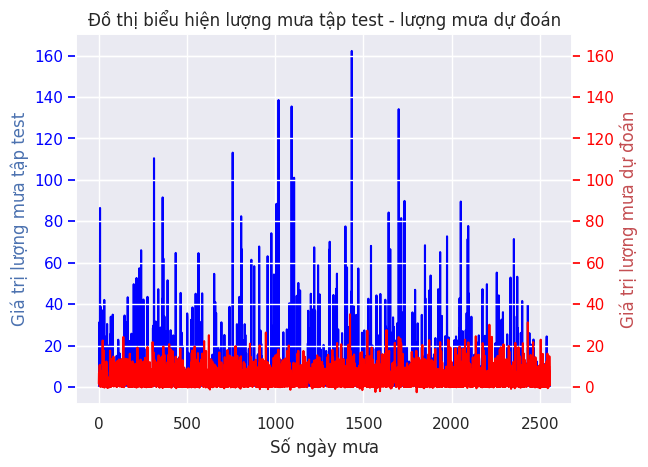

In [ ]:
#đánh giá hiệu suất trên tập test
y_pred_test_lgbm = model_LightGBM.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test_lgbm)
print('Mean absolute Error:', mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lgbm))
print('Root mean squared Error:', rmse)

r = r_squared(actual=y_test.values, predicted=y_pred_test_lgbm)
print("R_squared:", r)

nse = NSE(y_true=y_test.values, y_pred=y_pred_test_lgbm)
print("NSE:", nse)

# Dữ liệu cho trục y thứ nhất
x = range(len(y_test))
y1 = y_test

# Tạo đối tượng Axes thứ nhất
fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Số ngày mưa')
ax1.set_ylabel('Giá trị lượng mưa tập test', color='b')
ax1.tick_params('y', colors='blue')

# Dữ liệu cho trục y thứ hai
y2 = y_pred_test_lgbm

# Tạo đối tượng Axes thứ hai
ax2 = ax1.twinx()
ax2.plot(x, y2, 'red')
ax2.set_ylabel('Giá trị lượng mưa dự đoán', color='r')
ax2.tick_params('y', colors='red')
# Đặt giới hạn cho trục y2 dựa trên giới hạn của trục y1
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)

# Tiêu đề
plt.title('Đồ thị biểu hiện lượng mưa tập test - lượng mưa dự đoán')

# Hiển thị đồ thị
plt.show()

# **Hyperparameter Tunning**

In [ ]:
# Hàm RMSE custom
def RMSE(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)
rmse_scorer = make_scorer(RMSE)

def  MAE(y_test, y_pred):
    return mean_absolute_error(y_test, y_pred)
mae_scorer = make_scorer(MAE)

In [ ]:
# Define the hyperparameters you want to search over
n_estimators = [200, 250, 300]
max_depth = [6, 8, 10]
learning_rate = [0.3, 0.5, 0.8]
subsample = [0.5, 0.7, 0.8]


# Tạo scorer dựa trên RMSE
rmse_scorer = make_scorer(RMSE)

# KFold đảm bảo chia dữ liệu thành các fold.
kfold = KFold(n_splits=10, shuffle=True, random_state= 42)

## **Tunning XGBoost**

In [ ]:
# Define the XGBRegressor
model = xgb.XGBRegressor(booster = 'gbtree',
                        sampling_method = 'uniform',
                        tree_method = 'approx',
                        objective='reg:tweedie',
                        max_bin = 256,
                        tweedie_variance_power=1.8)

# Create a parameter grid
param_grid_xgb = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'subsample':subsample,
    'learning_rate': learning_rate,
}

#Đây là tạo một GridSearchCV object để tìm kiếm tập tham số tốt nhất cho mô hình.
#n_job=-1 : dùng CPU, cv=kfold: Sử dụng phương thức cross-validation cho k fold, verbose=1: In kết quả tối ưu hóa trong quá trình thực thi.
grid_search = GridSearchCV(xgb_model,
                           param_grid_xgb,
                           scoring = rmse_scorer,
                           cv=kfold,
                           verbose=1,
                           error_score='raise',
                          )
grid_result = grid_search.fit(X,y)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


In [ ]:
# Xác định index của kết quả có RMSE nhỏ nhất
best_index = grid_result.cv_results_['mean_test_score'].argmin()

# Truy cập giá trị RMSE và bộ siêu tham số tương ứng
best_rmse = grid_result.cv_results_['mean_test_score'][best_index]
best_params = grid_result.cv_results_['params'][best_index]

# In ra giá trị RMSE nhỏ nhất và bộ siêu tham số tương ứng
print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)

Best RMSE: 12.297049425809014
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


**Final Model**

In [ ]:
final_xgb_model = xgb.XGBRegressor(
                                   )
final_xgb_model.fit(X_train, y_train)

y_pred_train_xgb_mdel = final_xgb_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train_xgb_mdel)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb_mdel))
nse = NSE(y_true=y_train.values, y_pred=y_pred_train_xgb_mdel)
print('Mean absolute Error Train:', mae)
print('Root mean squared Error Train:', rmse)
print("NSE Train:", nse)

Mean absolute Error Train: 3.849374015069518
Root mean squared Error Train: 7.551112435896577
NSE Train: 0.6335798082049444


In [ ]:
# Đánh giá độ chính xác
mae = cross_val_score(xgb_model,X,y, cv=kfold, scoring=mae_scorer)
rmse = cross_val_score(xgb_model,X,y, cv=kfold, scoring=rmse_scorer)
nse = cross_val_score(xgb_model,X,y, cv=kfold, scoring=nse_scorer)
print(f'RMSE of each fold:')
print(rmse)
print(f'mean RMSE of Fold: {rmse.mean()}')
print(f'\nMAE of each fold:')
print(mae)
print(f'mean MAE of Fold: {mae.mean()}')
print(f'\nNSE of each fold:')
print(nse)
print(f'mean NSE of Fold: {nse.mean()}')

RMSE of each fold:
[14.23640352 13.32568315 11.40771718 12.4748041  11.96755606 10.41712601
 12.88533285 13.50763217 13.60590937 11.10733427]
mean RMSE of Fold: 12.493549869251869

MAE of each fold:
[6.18938165 5.892737   5.38626538 5.60771226 5.4442858  5.08304493
 6.04494062 6.17152168 6.06045902 5.30613396]
mean MAE of Fold: 5.71864822969078

NSE of each fold:
[-0.00687943  0.01429357  0.07896817  0.02526474  0.03870766  0.07019596
  0.04121616  0.02727813  0.01171996  0.04230373]
mean NSE of Fold: 0.03430686540003873


Mean absolute Error: 6.6502103646072035
Root mean squared Error: 13.397046028815964
NSE: 0.0592843637100644


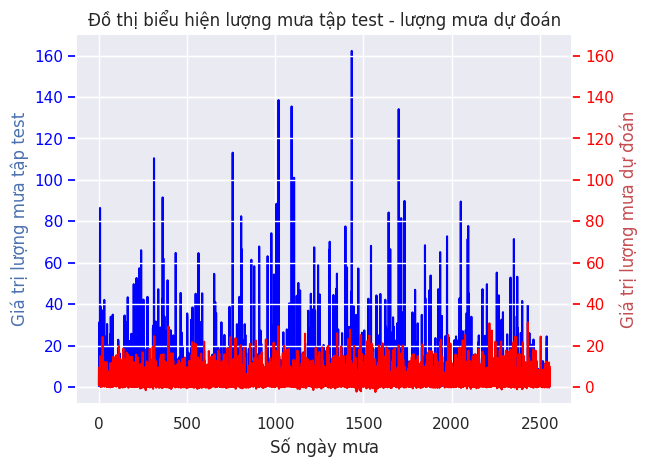

In [ ]:
y_pred_test_xgb_model = final_xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test_xgb_model)
nse = NSE(y_true=y_test.values, y_pred=y_pred_test_xgb_model)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_model))
print('Mean absolute Error:', mae)
print('Root mean squared Error:', rmse)
print("NSE:", nse)

# Dữ liệu cho trục y thứ nhất
x = range(len(y_test))
y1 = y_test

# Tạo đối tượng Axes thứ nhất
fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Số ngày mưa')
ax1.set_ylabel('Giá trị lượng mưa tập test', color='b')
ax1.tick_params('y', colors='blue')

# Dữ liệu cho trục y thứ hai
y2 = y_pred_test_xgb_model

# Tạo đối tượng Axes thứ hai
ax2 = ax1.twinx()
ax2.plot(x, y2, 'red')
ax2.set_ylabel('Giá trị lượng mưa dự đoán', color='r')
ax2.tick_params('y', colors='red')
# Đặt giới hạn cho trục y2 dựa trên giới hạn của trục y1
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)

# Tiêu đề
plt.title('Đồ thị biểu hiện lượng mưa tập test - lượng mưa dự đoán')

# Hiển thị đồ thị
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

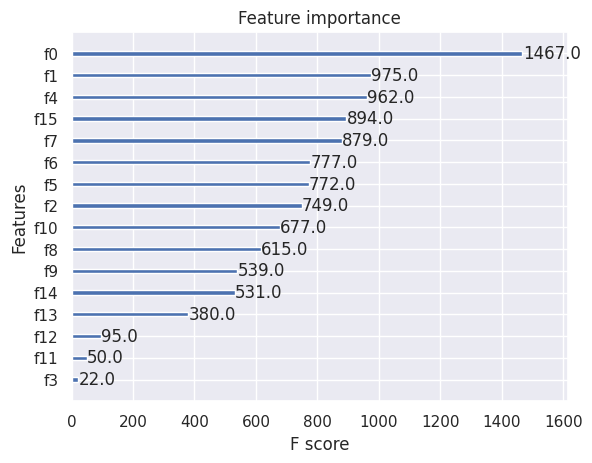

In [ ]:
final_xgb_model.get_params()
xgb.plot_importance(final_xgb_model)

## **Tunning LightGBM**

In [ ]:
params = {
    'objective': 'tweedie',
    'metric': 'mean_squared_error',
    'force_row_wise': 'True',
    'boosting_type':'dart'
}
model_LightGBM = lgb.LGBMRegressor(**params)

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model_LightGBM,
    param_grid=param_grid,
    cv=kfold,
    scoring=rmse_scorer,
    error_score='raise'
)
grid_result=grid_search.fit(X,y)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 11506, number of used features: 16
[LightGBM] [Info] Start training from score 1.645159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [ ]:
# Xác định index của kết quả có RMSE nhỏ nhất
best_index = grid_result.cv_results_['mean_test_score'].argmin()

# Truy cập giá trị RMSE và bộ siêu tham số tương ứng
best_rmse = grid_result.cv_results_['mean_test_score'][best_index]
best_params = grid_result.cv_results_['params'][best_index]

# In ra giá trị RMSE nhỏ nhất và bộ siêu tham số tương ứng
print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)

Best RMSE: 12.02687989863001
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


**Final Model**

In [ ]:
params = {
    'objective': 'regression',
    'boost': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators':200,
    'tree_learner': 'serial',
    'verbosity': 1
}

model_train_lightgbm = lgb.LGBMRegressor(**params)

# Fit the model with early stopping
model_train_lightgbm.fit(
    X_train,
    y_train
)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 10227, number of used features: 16
[LightGBM] [Info] Start training from score 5.185998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMRegressor(boost='gbdt', max_depth=8, n_estimators=200,
              objective='regression', tree_learner='serial', verbosity=1)

In [ ]:
y_pred_train_lgb_model = model_train_lightgbm.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train_lgb_model)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_lgb_model))
nse = NSE(y_true=y_train.values, y_pred=y_pred_train_lgb_model)
print('Mean absolute Error Train:', mae)
print('Root mean squared Error Train:', rmse)
print("NSE Train:", nse)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean absolute Error Train: 4.366823442960676
Root mean squared Error Train: 8.006614805100178
NSE Train: 0.58803967284415


In [ ]:
y_pred_test_lgb_model = model_train_lightgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test_lgb_model)
nse = NSE(y_true=y_test.values, y_pred=y_pred_test_lgb_model)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lgb_model))
print('Mean absolute Error:', mae)
print('Root mean squared Error:', rmse)
print("NSE:", nse)

[LightGBM] [Warning] boosting is set with boost=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean absolute Error: 6.724600147631402
Root mean squared Error: 13.32524604143829
NSE: 0.06934066642809


In [ ]:
# Đánh giá độ chính xác
mae = cross_val_score(model_train_lightgbm,X,y, cv=kfold, scoring=mae_scorer)
rmse = cross_val_score(model_train_lightgbm,X,y, cv=kfold, scoring=rmse_scorer)
nse = cross_val_score(model_train_lightgbm,X,y, cv=kfold, scoring=nse_scorer)
print(f'RMSE of each fold:')
print(rmse)
print(f'mean RMSE of Fold: {rmse.mean()}')
print(f'\nMAE of each fold:')
print(mae)
print(f'mean MAE of Fold: {mae.mean()}')
print(f'\nNSE of each fold:')
print(nse)
print(f'mean NSE of Fold: {nse.mean()}')

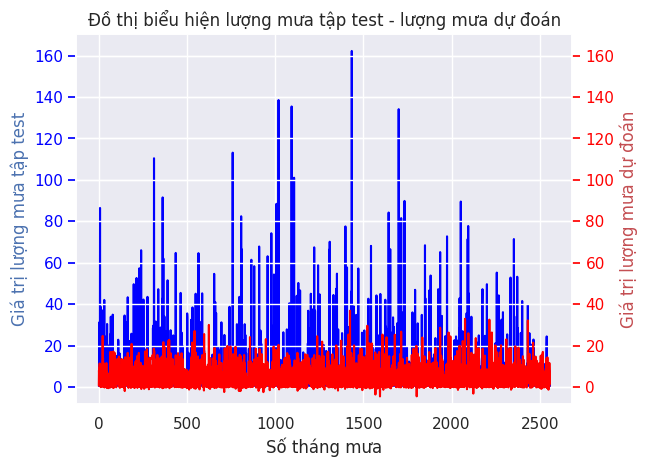

In [ ]:
# Dữ liệu cho trục y thứ nhất
x = range(len(y_test))
y1 = y_test

# Tạo đối tượng Axes thứ nhất
fig, ax1 = plt.subplots()
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Số tháng mưa')
ax1.set_ylabel('Giá trị lượng mưa tập test', color='b')
ax1.tick_params('y', colors='blue')

# Dữ liệu cho trục y thứ hai
y2 = y_pred_test_lgb_model

# Tạo đối tượng Axes thứ hai
ax2 = ax1.twinx()
ax2.plot(x, y2, 'red')
ax2.set_ylabel('Giá trị lượng mưa dự đoán', color='r')
ax2.tick_params('y', colors='red')
# Đặt giới hạn cho trục y2 dựa trên giới hạn của trục y1
y1_min, y1_max = ax1.get_ylim()
ax2.set_ylim(y1_min, y1_max)

# Tiêu đề
plt.title('Đồ thị biểu hiện lượng mưa tập test - lượng mưa dự đoán')

# Hiển thị đồ thị
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

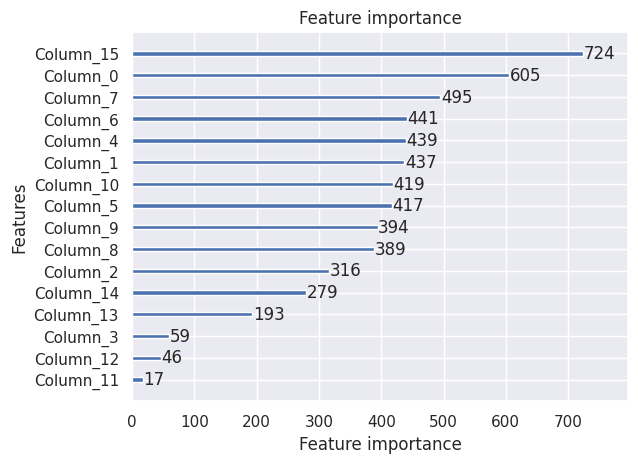

In [ ]:
model_train_lightgbm.get_params()
lgb.plot_importance(model_train_lightgbm)